**CNN Method - CIFAR**

In [ ]:
# cnn_cifar10.py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Data Loading and Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

# 2. Define Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(8 * 8 * 128, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)

# 3. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 4. Training Loop
train_losses, test_accuracies = [], []

def train_model(num_epochs=10):
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        test_acc = test_model()
        test_accuracies.append(test_acc)
        print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Test Acc: {test_acc:.2f}%")


# 5. Evaluation
def test_model():
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

train_model(num_epochs=10)
test_model()


Epoch 1, Loss: 1.5661, Test Acc: 58.09%
Epoch 2, Loss: 1.1900, Test Acc: 64.84%
Epoch 3, Loss: 1.0404, Test Acc: 68.26%
Epoch 4, Loss: 0.9407, Test Acc: 70.40%
Epoch 5, Loss: 0.8789, Test Acc: 73.66%
Epoch 6, Loss: 0.8315, Test Acc: 74.53%
Epoch 7, Loss: 0.7971, Test Acc: 75.78%
Epoch 8, Loss: 0.7671, Test Acc: 76.65%
Epoch 9, Loss: 0.7356, Test Acc: 77.90%
Epoch 10, Loss: 0.7086, Test Acc: 77.63%


77.87

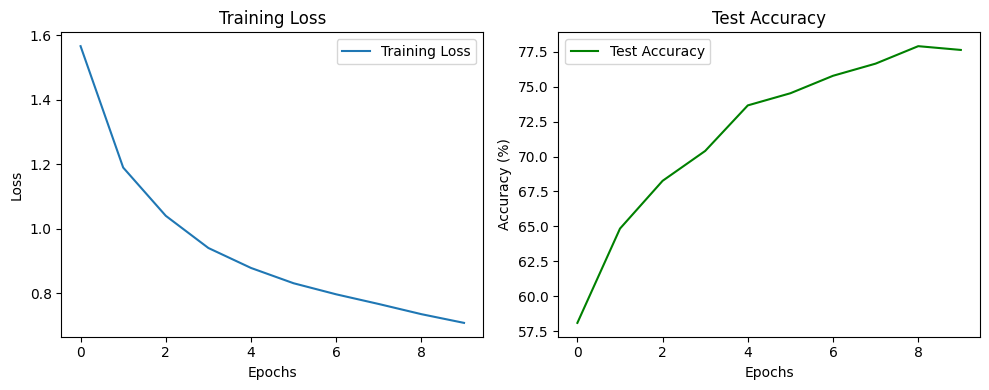

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()


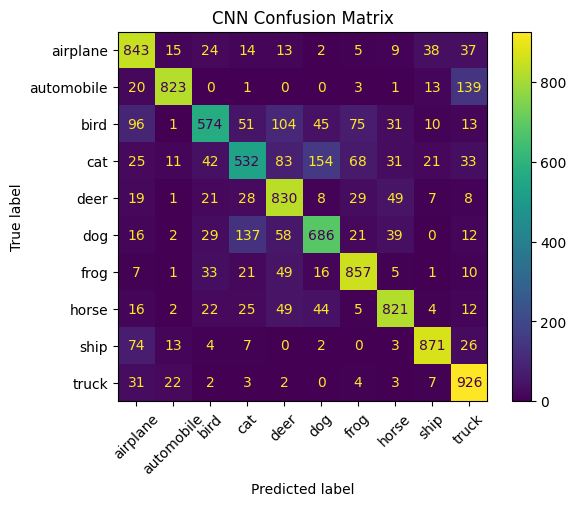

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions
all_preds = []
all_labels = []
net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainset.classes)
disp.plot(xticks_rotation=45)
plt.title("CNN Confusion Matrix")
plt.show()


Traditional Method Part **2**

In [ ]:
# traditional_cv_cifar10
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToPILImage
from tqdm import tqdm

# Parameters
NUM_CLUSTERS = 100  # Number of visual words
NUM_TRAIN = 5000
NUM_TEST = 1000

# Loading the CIFAR-10 data
cifar_train = CIFAR10(root='./data', train=True, download=True)
cifar_test = CIFAR10(root='./data', train=False, download=True)

# ORB Feature Extractor
orb = cv2.ORB_create(nfeatures=100)

# Helper to convert and extract ORB descriptors
def extract_orb_descriptors(img_pil):
    img = np.array(img_pil.resize((64, 64)).convert('L'))  # Resize & grayscale
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return descriptors

# First we extract descriptors from training images
all_descriptors = []
train_features = []
train_labels = []

print("Extracting ORB descriptors from training set...")
for i in tqdm(range(NUM_TRAIN)):
    img, label = cifar_train[i]
    descriptors = extract_orb_descriptors(img)
    if descriptors is not None:
        all_descriptors.extend(descriptors)
        train_features.append(descriptors)
        train_labels.append(label)

all_descriptors = np.array(all_descriptors)

#Second we use KMeans Clustering to build visual vocabulary
print("Clustering descriptors to form visual vocabulary...")
kmeans = MiniBatchKMeans(n_clusters=NUM_CLUSTERS, random_state=42, batch_size=1000)
kmeans.fit(all_descriptors)

#Third we build histogram for each image
def build_bow_histogram(descriptors, kmeans_model):
    if descriptors is None:
        return np.zeros(NUM_CLUSTERS)
    words = kmeans_model.predict(descriptors)
    hist, _ = np.histogram(words, bins=np.arange(NUM_CLUSTERS + 1))
    return hist

print("Building histograms for training images...")
X_train = np.array([build_bow_histogram(desc, kmeans) for desc in train_features])
y_train = np.array(train_labels)

#Repeating same for test set
test_features = []
test_labels = []

print("Extracting ORB descriptors from test set...")
for i in tqdm(range(NUM_TEST)):
    img, label = cifar_test[i]
    descriptors = extract_orb_descriptors(img)
    test_features.append(descriptors)
    test_labels.append(label)

print("Building histograms for test images...")
X_test = np.array([build_bow_histogram(desc, kmeans) for desc in test_features])
y_test = np.array(test_labels)

# Fifth is normalizing and training SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training SVM...")
svm = SVC(kernel='rbf', C=10, gamma=0.1)
svm.fit(X_train_scaled, y_train)

# final step - Evaluation
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Traditional CV (ORB + BoVW + SVM) Accuracy: {accuracy * 100:.2f}%")


Extracting ORB descriptors from training set...


100%|██████████| 5000/5000 [00:03<00:00, 1423.96it/s]


Clustering descriptors to form visual vocabulary...
Building histograms for training images...
Extracting ORB descriptors from test set...


100%|██████████| 1000/1000 [00:00<00:00, 2483.04it/s]


Building histograms for test images...
Training SVM...
Traditional CV (ORB + BoVW + SVM) Accuracy: 10.70%


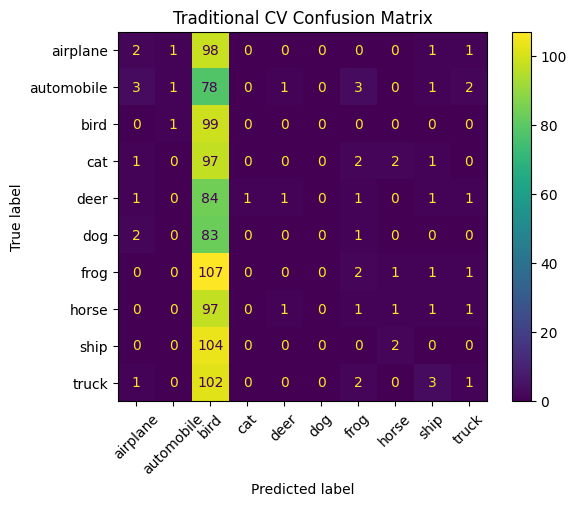

In [ ]:
#Confusion matrix for tradition Cv method
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar_test.classes)
disp.plot(xticks_rotation=45)
plt.title("Traditional CV Confusion Matrix")
plt.show()


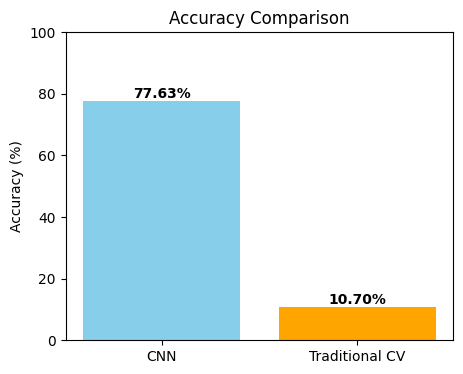

In [ ]:
#The CNN outperforms the traditional approach in classification accuracy and robustness due to its ability to learn task-specific features.#
plt.figure(figsize=(5, 4))
models = ['CNN', 'Traditional CV']
accuracies = [test_accuracies[-1], accuracy * 100]
colors = ['skyblue', 'orange']

plt.bar(models, accuracies, color=colors)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy (%)")
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.ylim(0, 100)
plt.show()


In [ ]:
"""1. Image Resolution is Too Low (32x32)
ORB and other keypoint-based descriptors are not optimized for small, low-detail images. Even with resizing to 64x64, CIFAR-10 lacks rich textures or gradients that ORB can pick up effectively.

2. Lack of Semantic Understanding
Traditional features are not semantically deep — they rely on edge corners and patterns, which may look similar across classes like cat and dog, or truck and automobile.

3. SVM Is Limited Without Good Features
SVM is a good classifier, but only if the features are meaningful. In this case, BoVW histograms are too coarse to represent object categories well.

4. Descriptors Might Be Sparse or Missing
A lot of images may return very few or no ORB descriptors, resulting in poor or zero histograms."""

'1. Image Resolution is Too Low (32x32)\nORB and other keypoint-based descriptors are not optimized for small, low-detail images. Even with resizing to 64x64, CIFAR-10 lacks rich textures or gradients that ORB can pick up effectively.\n\n2. Lack of Semantic Understanding\nTraditional features are not semantically deep — they rely on edge corners and patterns, which may look similar across classes like cat and dog, or truck and automobile.\n\n3. SVM Is Limited Without Good Features\nSVM is a good classifier, but only if the features are meaningful. In this case, BoVW histograms are too coarse to represent object categories well.\n\n4. Descriptors Might Be Sparse or Missing\nA lot of images may return very few or no ORB descriptors, resulting in poor or zero histograms.'